In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from segment_anything import sam_model_registry, SamPredictor


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ha4agte0
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ha4agte0
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=0258d165d6c6979b41da760d8b1fa7935afad9d290a0f187b1a03d9df72f7134
  Stored in directory: /tmp/pip-ephem-wheel-cache-w2934023/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


Download SAM checkpoints.

In [2]:
!wget -nc https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth #Smallest
!wget -nc https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
!wget -nc https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


--2025-11-21 20:50:37--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.123, 13.35.37.84, 13.35.37.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   511MB/s    in 0.7s    

2025-11-21 20:50:37 (511 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]

--2025-11-21 20:50:37--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.123, 13.35.37.84, 13.35.37.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1249524607 (1.2G) [binary/octet-stream]
Saving to: ‘sam_vit_l_

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sam_models = {
    "SAM_B": sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth"),
    "SAM_L": sam_model_registry["vit_l"](checkpoint="sam_vit_l_0b3195.pth"),
    "SAM_H": sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth"),
}

predictors = {}
for name, model in sam_models.items():
    model.to(device)
    predictors[name] = SamPredictor(model)
predictors



{'SAM_B': <segment_anything.predictor.SamPredictor at 0x7c63342a3ec0>,
 'SAM_L': <segment_anything.predictor.SamPredictor at 0x7c6336b260c0>,
 'SAM_H': <segment_anything.predictor.SamPredictor at 0x7c63342a3890>}

SAM returns 3 candidate masks (each the same size as the input image).
Each gets a score from the mask quality head (estimates how good the mask is relative to ground truth IoU for a different set of masks).
- Represents mask quality
- Higher score means more confidence that the mask is correct.

In [25]:
IMG_DIR = "/content/rgb"
rgb_images = sorted(os.listdir(IMG_DIR))

results = []
mask_dict = {}

for img in rgb_images:
    img_num = img.split(".")[0]
    rgb_path = os.path.join(IMG_DIR, img)

    rgb = cv2.imread(rgb_path)[:, :, ::-1]
    H, W, _ = rgb.shape

    # Only if we want to assume that the centre cell is part of the foreground
    # pt = np.array([[W//2, H//2]]) # Example point for which we would like a label
    # lb = np.array([1])   # Hint given, that we can have foreground and background points (1 vs 0)

    for model, predictor in predictors.items():
        predictor.set_image(rgb)

        masks, scores, logits = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=None,
            multimask_output=True,
        )


        for i in range(len(scores)):
            results.append({
                "file": img_num,
                "model": model,
                "candidate_mask": int(i),
                "sam_score": float(scores[i])
            })

            mask_dict[(img_num, model, i)] = masks[i]



In [ ]:
df = pd.DataFrame(results)
df

,file,model,candidate_mask,sam_score
0,00,SAM_B,0,0.894616
1,00,SAM_B,1,0.821068
2,00,SAM_B,2,0.366237
3,00,SAM_L,0,0.591067
4,00,SAM_L,1,0.471999
5,00,SAM_L,2,0.881106
6,00,SAM_H,0,0.586952
7,00,SAM_H,1,0.887322
8,00,SAM_H,2,0.951183
9,03,SAM_B,0,0.874540


In [27]:
df_summary = df.groupby(["model"])["sam_score"].agg(["mean", "std", "min", "max"])
df_summary


,mean,std,min,max
model,,,,
SAM_B,0.655400,0.239183,0.309105,0.894616
SAM_H,0.810550,0.160543,0.555475,0.982933
SAM_L,0.667567,0.181340,0.471999,0.931542


In [28]:
best_mask = df.sort_values("sam_score", ascending=False).groupby("model").head(1)
best_mask


,file,model,candidate_mask,sam_score
44,22,SAM_H,2,0.982933
41,22,SAM_L,2,0.931542
0,00,SAM_B,0,0.894616


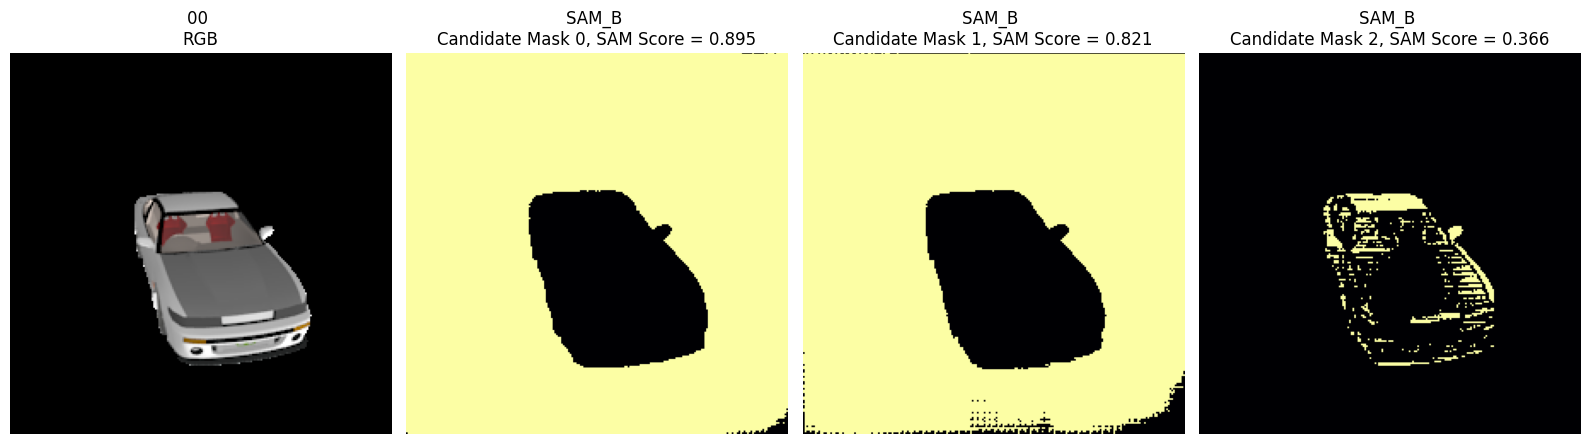

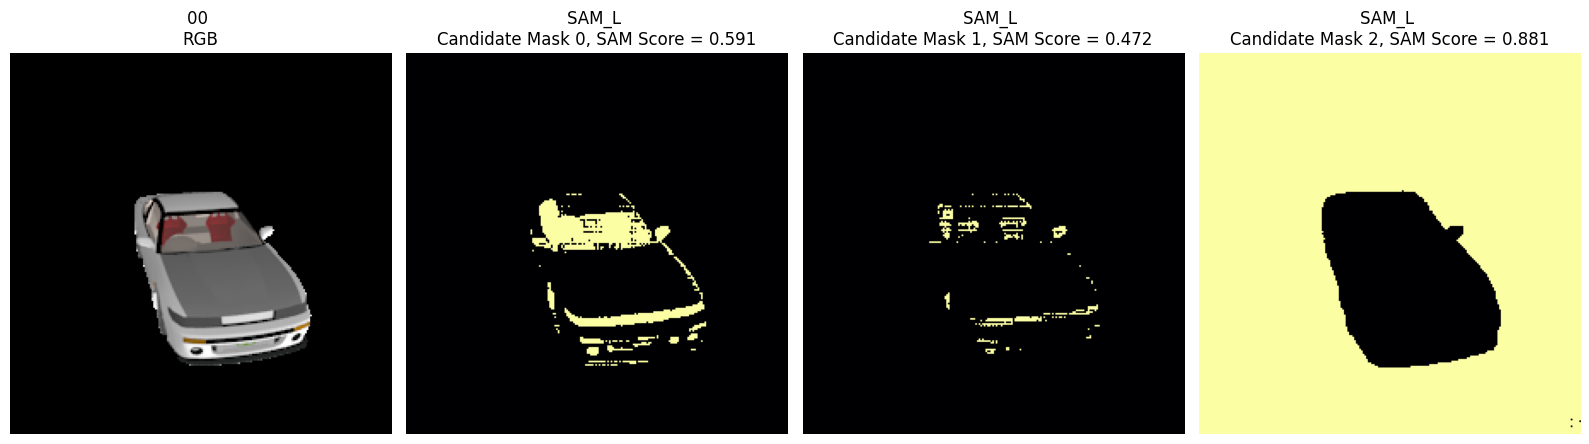

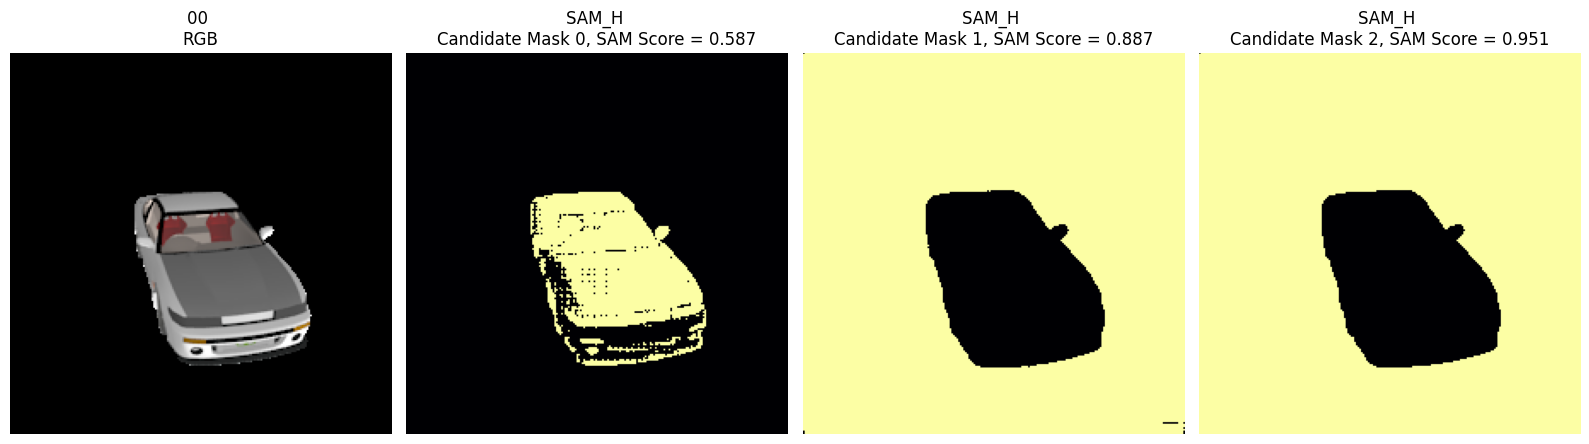

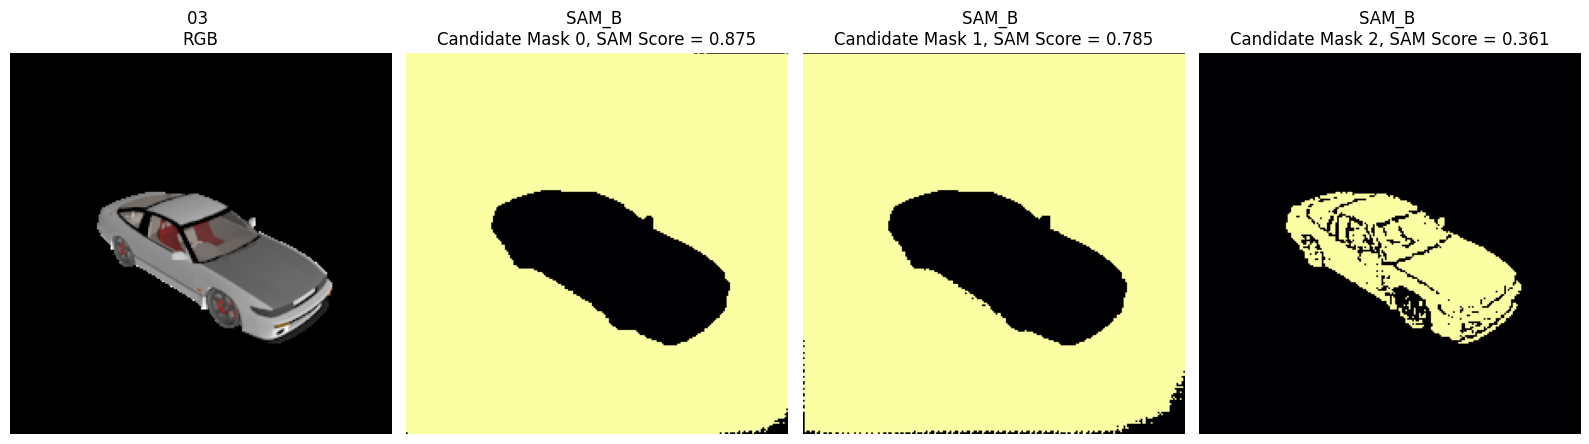

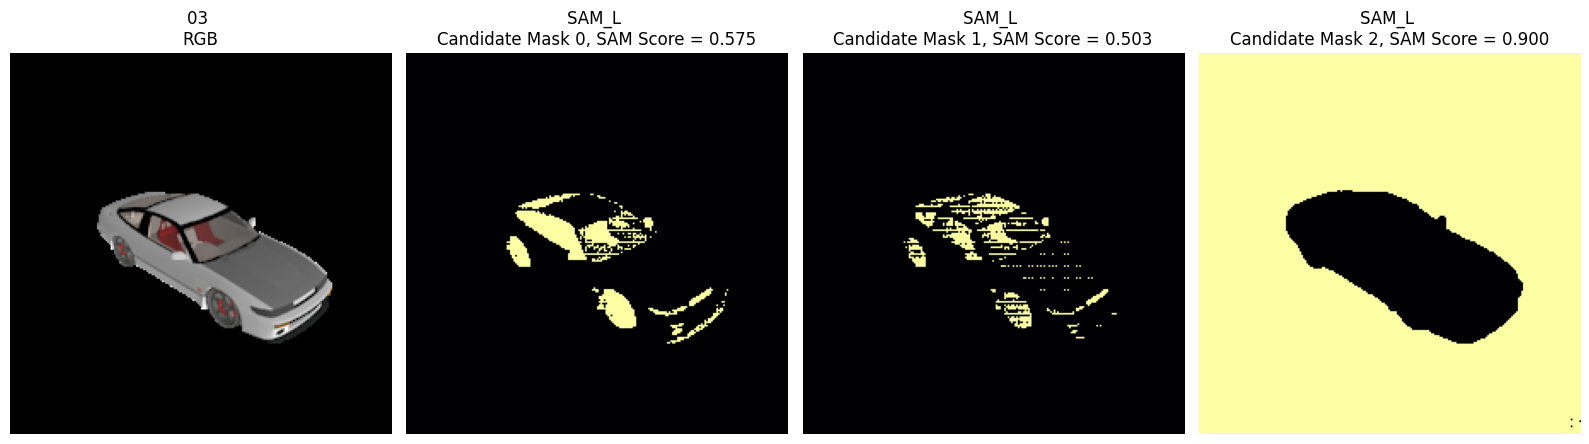

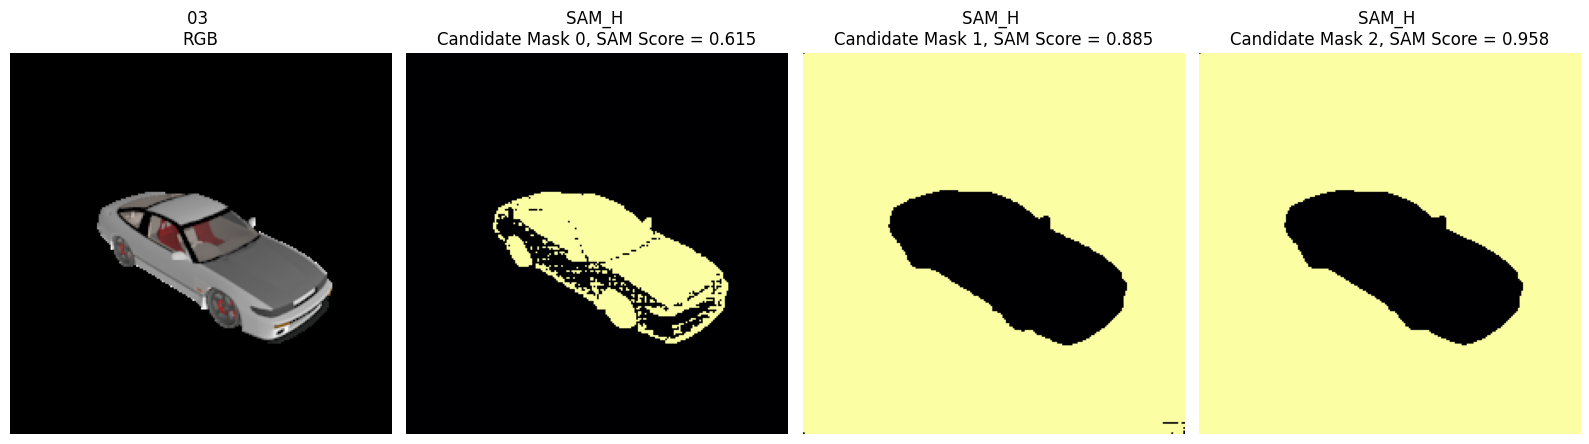

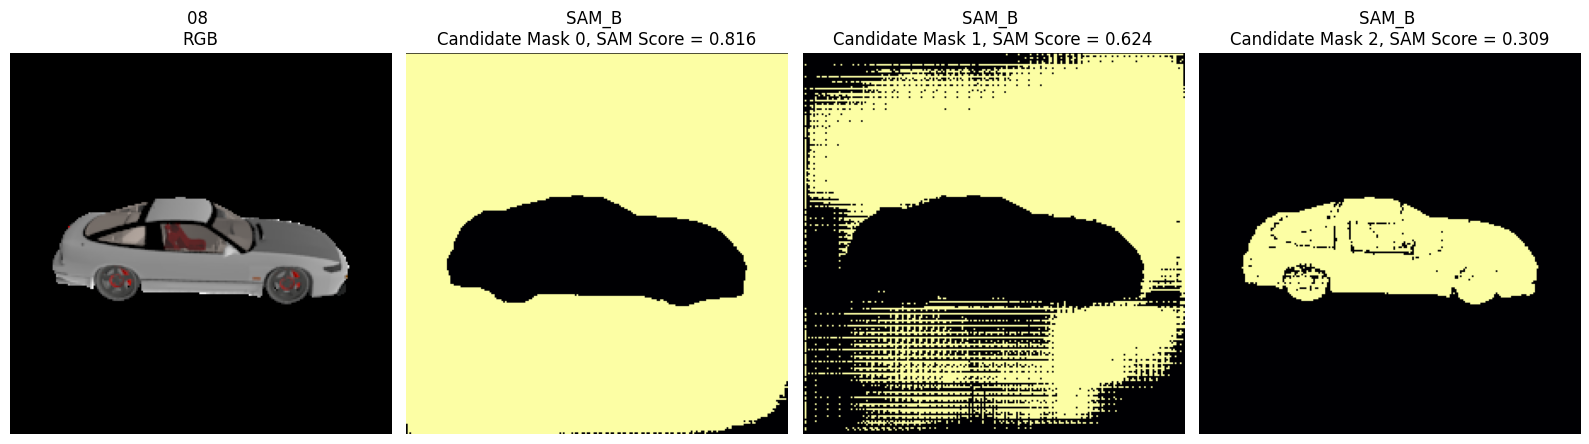

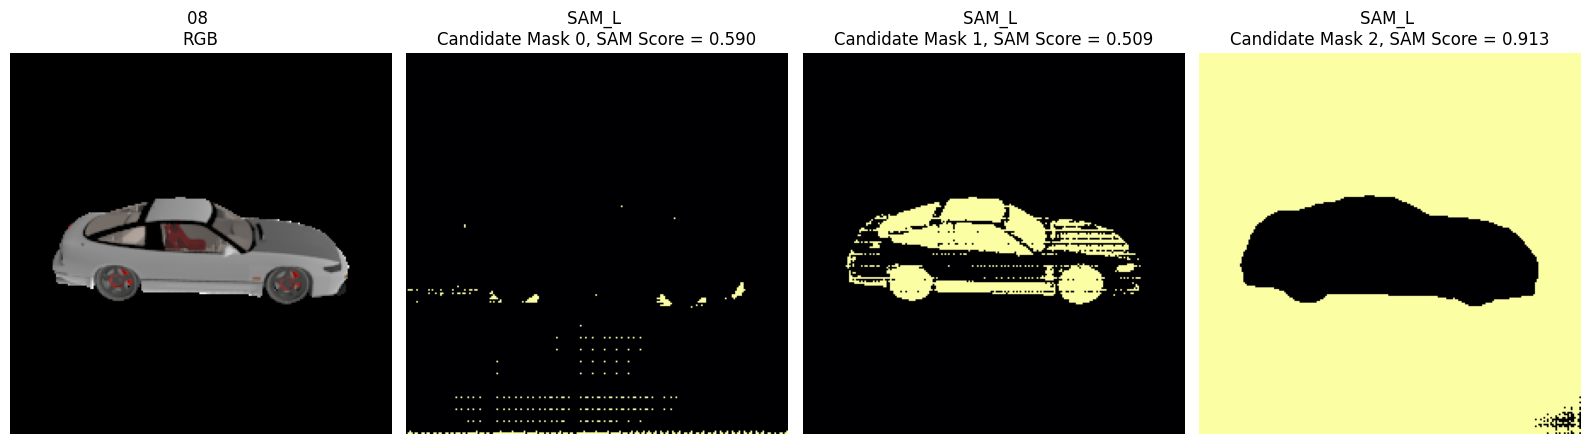

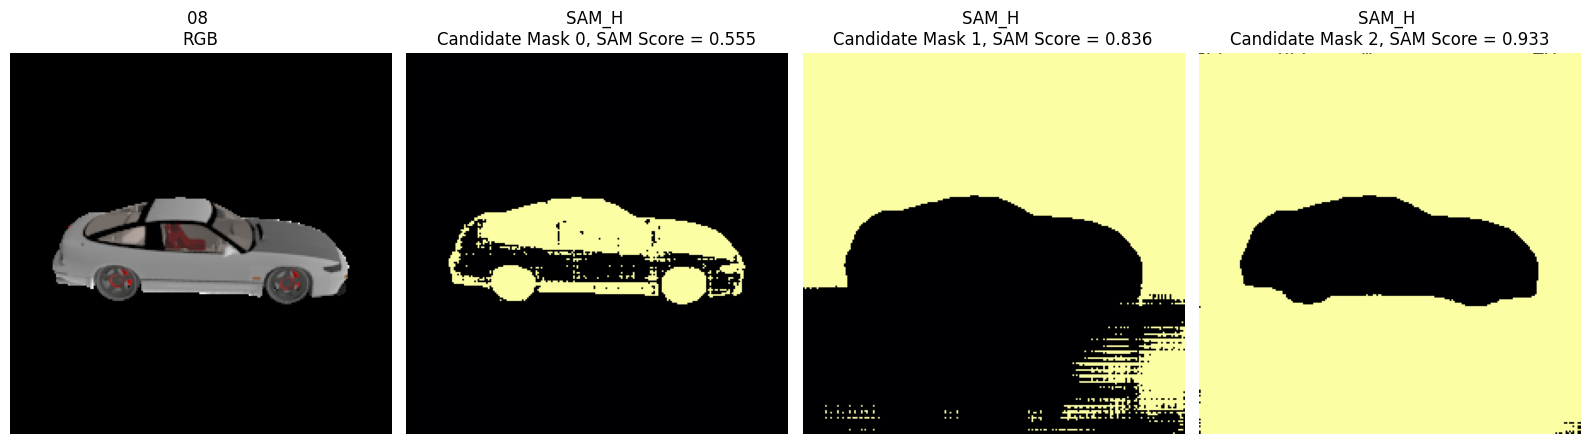

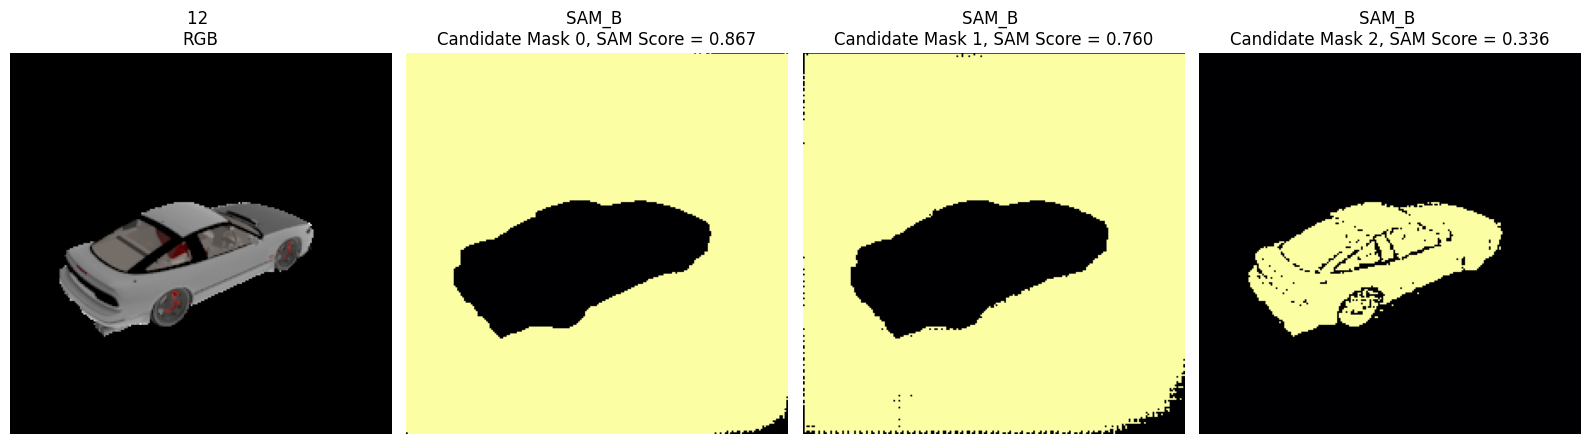

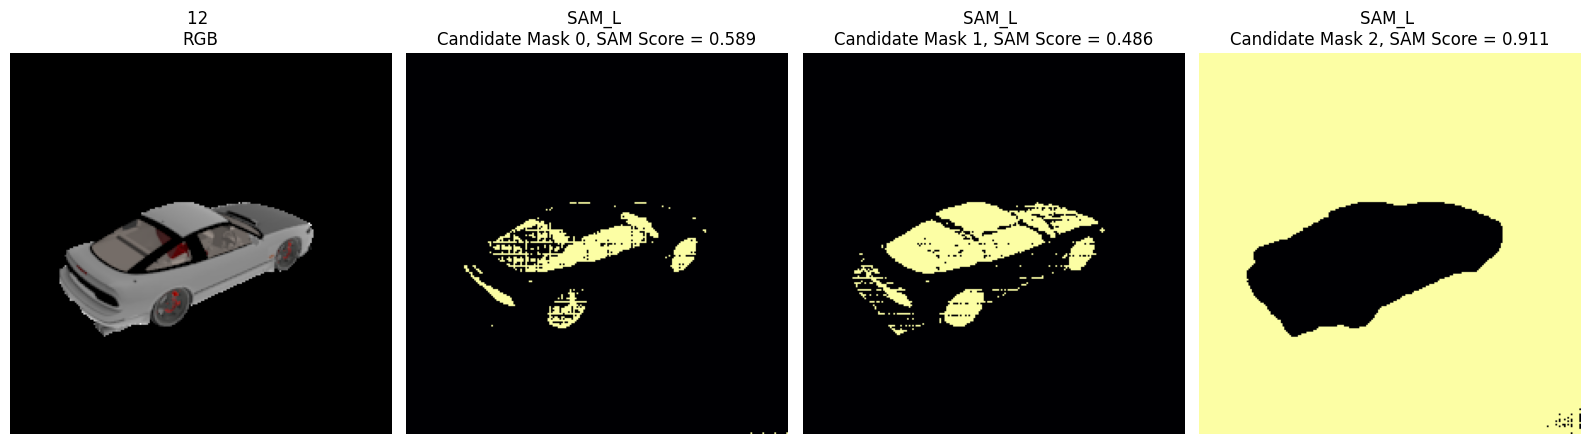

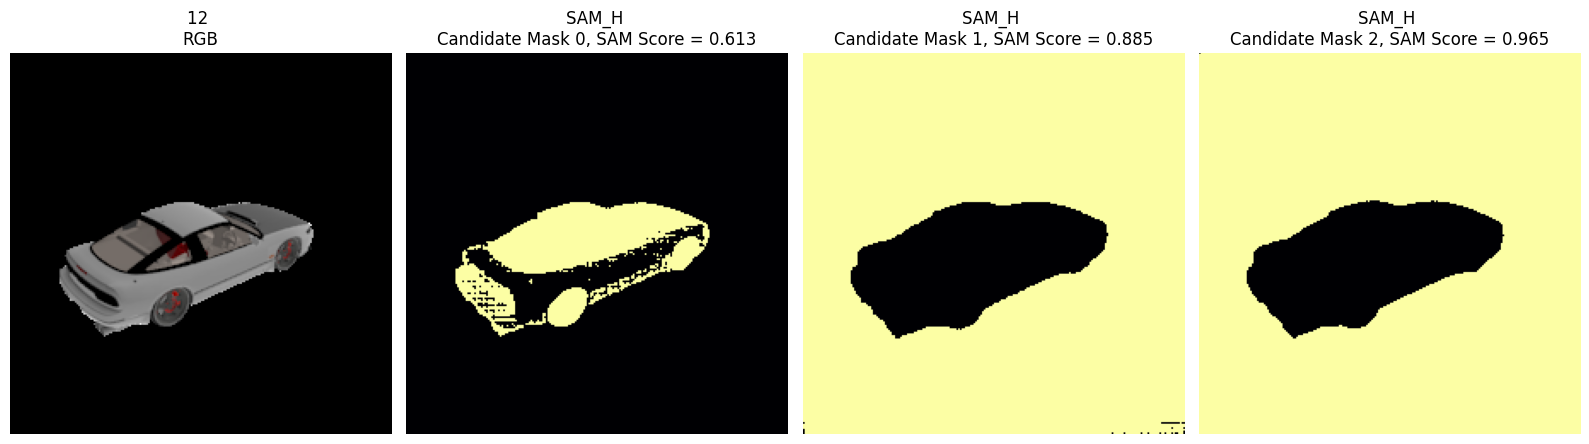

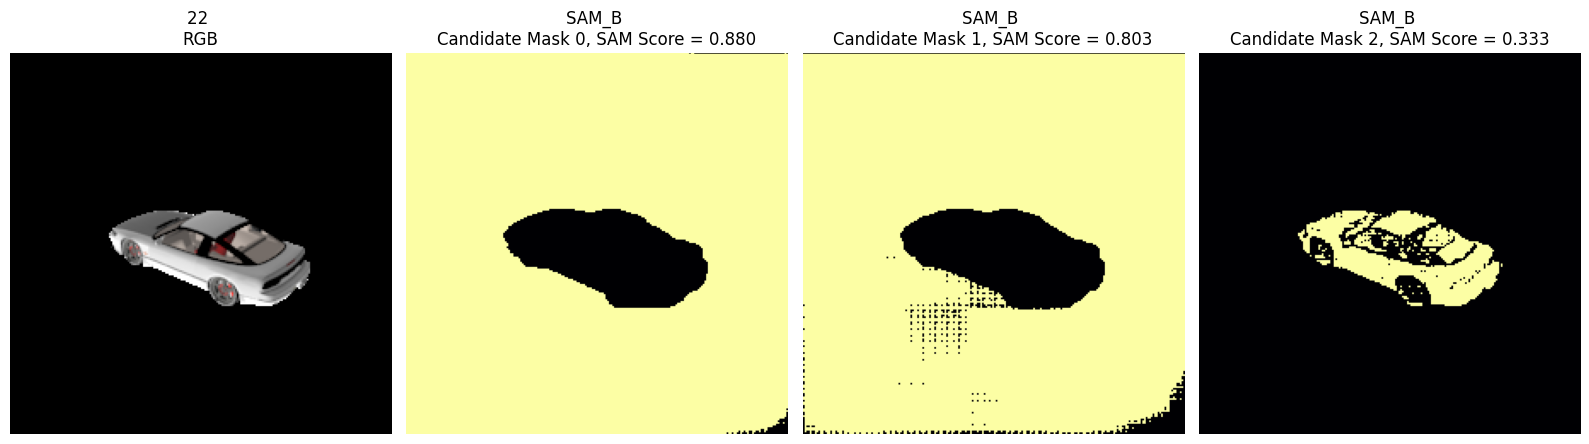

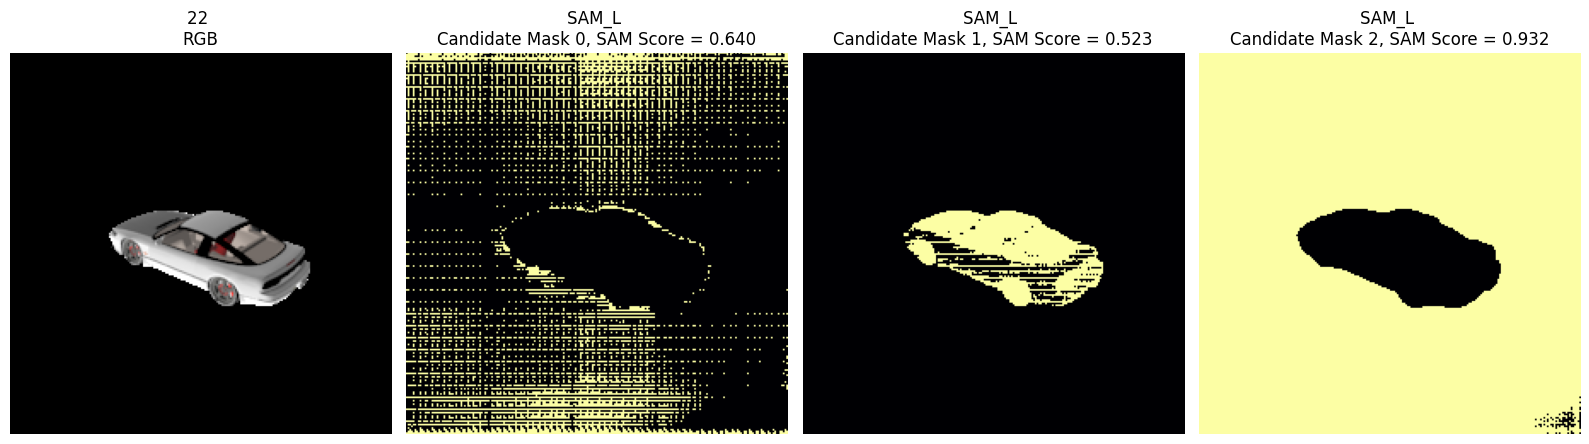

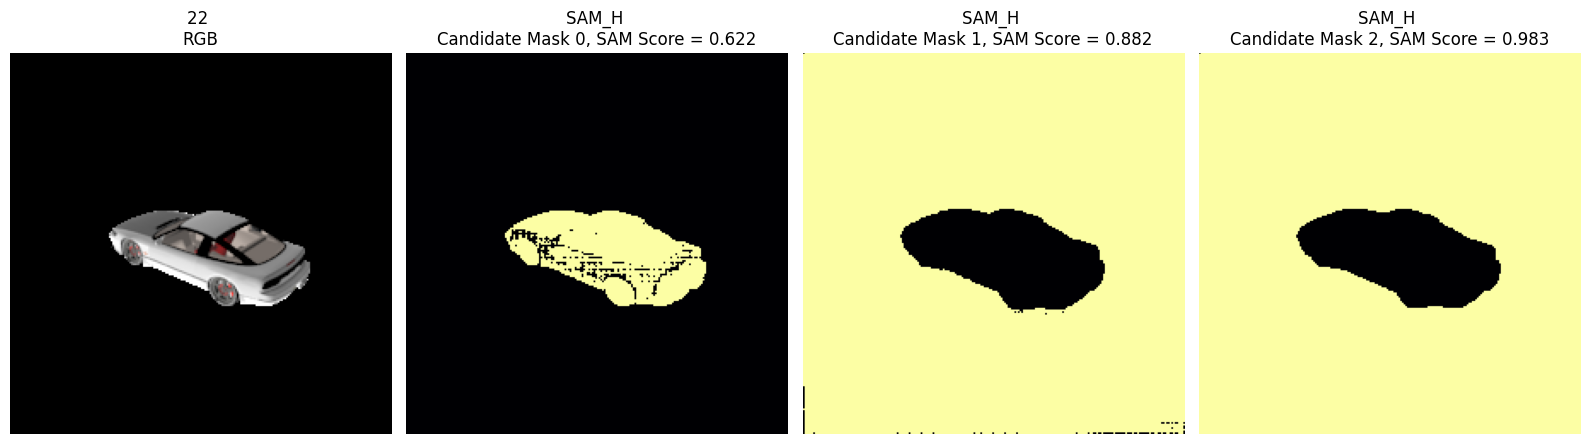

In [29]:
def vis_masks(IMG_DIR, results, mask_store):
    groups = {}
    for r in results:
        key = (r["file"], r["model"])
        groups.setdefault(key, []).append(r)

    for (img_num, model), entries in groups.items():
        rgb_path = os.path.join(IMG_DIR, f"{img_num}.png")
        rgb = cv2.imread(rgb_path)[:, :, ::-1]

        entries = sorted(entries, key=lambda x: x['candidate_mask'])

        fig = plt.figure(figsize=(4 * (1 + len(entries)), 5))
        ax = fig.add_subplot(1, 1 + len(entries), 1)
        ax.imshow(rgb)
        ax.set_title(f"{img_num} \nRGB")
        ax.axis("off")

        for j, e in enumerate(entries):
            mask = mask_store[(img_num, model, e["candidate_mask"])]
            ax = fig.add_subplot(1, 1 + len(entries), j + 2)
            ax.imshow(mask, cmap="inferno")
            ax.set_title(f"{model} \nCandidate Mask {e['candidate_mask']}, SAM Score = {e['sam_score']:.3f}")
            ax.axis("off")

        plt.tight_layout()
        plt.show()

vis_masks(IMG_DIR, results, mask_dict)
